# 并行

本节介绍三种实现并行的方法：

- 节点并行
- Map-reduce
- Sub-graphs


In [1]:
import os
import time
import operator

from dotenv import load_dotenv
from typing import Annotated
from datetime import datetime
from pydantic import BaseModel
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Send
from IPython.display import Image, display
from concurrent.futures import ThreadPoolExecutor

# 加载模型配置
_ = load_dotenv()

# 加载模型
model_name = "qwen3-max"
llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model=model_name,
    temperature=0.7,
)

## 一、节点并行

节点并行很容易实现，使用 `StateGraph` 创建带并行节点的工作流就可以。

下面是一个简单的节点并行的例子。你可以观察节点运行的时间戳，确认它们是否真的在并行。

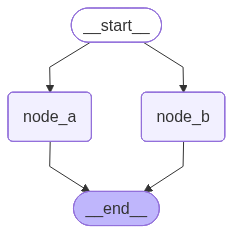

In [2]:
# 创建并行节点a
def node_a(state: MessagesState):
    start_time = datetime.now()
    print(f"[node_a] 进入函数时间: {start_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    # 使用 sleep 模拟占用时间
    time.sleep(2)

    end_time = datetime.now()
    print(f"[node_a] 退出函数时间: {end_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    return {'messages': [HumanMessage(
        content=f'节点a运行了{round((end_time - start_time).total_seconds(), 3)}秒'
    )]}

# 创建并行节点b
def node_b(state: MessagesState):
    start_time = datetime.now()
    print(f"[node_b] 进入函数时间: {start_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    # 使用 sleep 模拟占用时间
    time.sleep(4)

    end_time = datetime.now()
    print(f"[node_b] 退出函数时间: {end_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    return {'messages': [HumanMessage(
        content=f'节点b运行了{round((end_time - start_time).total_seconds(), 3)}秒'
    )]}

# 创建图
builder = StateGraph(MessagesState)

# 添加节点
builder.add_node('node_a', node_a)
builder.add_node('node_b', node_b)

# 添加边
builder.add_edge(START, 'node_a')
builder.add_edge(START, 'node_b')
builder.add_edge('node_a', END)
builder.add_edge('node_b', END)

# 编译图
my_graph = builder.compile(name='my-graph')
my_graph

In [3]:
# 调用图
response = my_graph.invoke({
    'messages': [HumanMessage(content='执行 node_a 和 node_b')]
})

for message in response['messages']:
    message.pretty_print()

[node_b] 进入函数时间: 2025-12-11 21:36:24.336[node_a] 进入函数时间: 2025-12-11 21:36:24.336

[node_a] 退出函数时间: 2025-12-11 21:36:26.341
[node_b] 退出函数时间: 2025-12-11 21:36:28.341
================================ Human Message =================================

执行 node_a 和 node_b
================================ Human Message =================================

节点a运行了2.005秒
================================ Human Message =================================

节点b运行了4.006秒


> **Note**
> 
> 若想了解节点的执行顺序，推荐阅读 [parallelization.ipynb](https://github.com/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb).

## 二、Map-reduce

学过 [Hadoop](https://www.luochang.ink/posts/hadoop_intro/) 的人都知道，map-reduce 是一个「先并行，后归约」的过程。这个概念被借鉴到 Agent 这里，变成了「先发散，后收敛」。借鉴过来之后，它的内涵其实变简单了，简单到不用 LangGraph 也能实现。那为什么还要用 LangGraph 呢？当然是因为用 LangGraph 写的 map-reduce 更标准化，可读性也更强一些。

> **Note**
> 🙆 八卦的心，就是爱（编程）的魔法。

下面从一个非常实际的问题入手：女神不回消息怎么办！！！

我们来创建几种人设：

- 男神
- 巨魔
- 舔狗
- 渣男
- 奶狗弟弟
- 社恐宅男
- 霸道总裁
- 茶茶的男生 💅💅💅
- 文艺长发男
- 萌萌二次元

你一定非常好奇，这些人会如何应对。下面我们来揭秘。

### 1）创建上下文的 schema

In [4]:
# 角色
class Roles(BaseModel):
    roles: list[str]

# 单个角色
class Role(BaseModel):
    role: str

# 单个回复
class Response(BaseModel):
    response: str

# 最佳回复的 ID
class BestResponse(BaseModel):
    id: int

# 全局上下文
class Overall(TypedDict):
    roles: list[str]
    responses: Annotated[list, operator.add]
    best_response: str

### 2）创建提示词模版

In [5]:
# 角色的提示词
role_prompt = "女神又不回你消息了，作为一个{role}，你应该如何一句话回复女神？请以JSON格式返回，包含response字段"

# 最佳回复的提示词
best_response_prompt = """下面是几种类型的男生，面对女神不回消息的情况，做出的反应。
你觉得以下哪种回复最能挽回女神的心，请返回对应的ID。
注意哦，第一条反应对应的是0号ID。并以JSON格式返回，包含id字段
下面是男生们的反应：\n\n{responses}"""

### 3）创建节点

这里的魔法在于我们使用 [Send](https://docs.langchain.com/oss/python/langgraph/graph-api#send) 函数，将角色分发给 `generate_response` 节点进行角色回复生成。

In [6]:
# 使用 Send 函数分发角色
def continue_to_responses(state: Overall):
    return [ Send("generate_response", {"role": r}) for r in state["roles"] ]

# 角色回复节点：生成每个角色的回复
def generate_response(state: Role):
    prompt = role_prompt.format(role=state["role"])
    response = llm.with_structured_output(Response).invoke(prompt)
    return {"responses": [response.response]}

# 最佳回复节点：返回最佳回复
def best_response(state: Overall):
    responses = "\n\n".join(state["responses"])
    prompt = best_response_prompt.format(responses=responses)
    response = llm.with_structured_output(BestResponse).invoke(prompt)
    return {"best_response": state["responses"][response.id]}

> **Note**
> 我们允许 `generate_response` 节点的 `state` 的 schema 与上游节点不同。因为 `generate_response` 节点是并行执行的，所以这个 schema 是特殊的，不需要与全局 schema（`Overall`）相同。

### 4）编译图

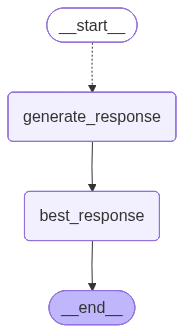

In [7]:
# 定义Doge子图的输出Schema
class DogeOutput(TypedDict):
    responses: list[str]
    best_response: str

# 创建图
doge_builder = StateGraph(Overall, output_schema=DogeOutput)

# 添加节点
doge_builder.add_node("generate_response", generate_response)
doge_builder.add_node("best_response", best_response)

# 添加边
doge_builder.add_conditional_edges(START, continue_to_responses, ["generate_response"])
doge_builder.add_edge("generate_response", "best_response")
doge_builder.add_edge("best_response", END)

# 编译图
doge_graph = doge_builder.compile(name='best-response')
doge_graph

In [8]:
# 调用图
roles = ["男神", "巨魔", "舔狗", "渣男", "奶狗弟弟", "社恐宅男",
         "霸道总裁", "茶茶的男生 💅💅💅", "文艺长发男", "萌萌二次元"]
response = doge_graph.invoke({"roles": roles})

In [9]:
# 最佳回复
print(f"最受 {model_name} 喜爱的回复：{response['best_response']}")

最受 qwen3-max 喜爱的回复：看来我的消息在你那儿成了未读的收藏，那我先去修炼成更值得你点开的样子。


In [10]:
# 所有回复
for role, resp in zip(roles, response["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【男神】
看来我的消息在你那儿成了未读的收藏，那我先去修炼成更值得你点开的样子。

【巨魔】
看来我的消息在你的已读不回列表里排到退休了，要不要给我发个‘安息’通知？

【舔狗】
没事，你忙你的，我随时都在。

【渣男】
刚在忙，没看到消息，不过你一不说话我就开始想你了。

【奶狗弟弟】
姐姐是不是在忙呀？不着急回我，但我会一直乖乖等你的～

【社恐宅男】
刚刚在打游戏/看番，看到消息有点紧张，不知道该怎么回你才好 😅

【霸道总裁】
我的时间很贵，但你的沉默更让我在意——现在，立刻回我。

【茶茶的男生 💅💅💅】
宝～是在忙吗？茶茶等你回消息等到花都谢啦 💅✨

【文艺长发男】
风起了，长发拂过未读的消息，我在字句间等你回眸，哪怕只是轻轻一点。

【萌萌二次元】
呜...女神大人是不是在忙呀？(๑•̀ㅂ•́)و✧ 我会乖乖等你回消息的！



## 三、Sub-graphs

已经写好的图，可以放到父图里面作为 **子图**（Sub-graphs）调用。这意味着我们可以复用已经写好的图。

> **Note**
> 不是哥们！女神不回消息这个话题真好用吧！让我们继续这个话题。

上一节创建的图 `doge_graph` 只产出了一条“最佳”回复，这真的够吗？罒ω罒

不够不够，必须再加一个工作流以策万全！

### 1）创建一个工作流

下面我们创建一个工作流。它不像 `doge_graph` 那样需要指定人设，而是可以自动生成 `n` 个新人设，再生成这些人设的回复。

In [11]:
# 定义ReAct子图的全局Schema
class ReActState(TypedDict):
    roles: list[str]
    n: int
    responses: list[str]

# 发散性地生成角色
def generate_roles(state: ReActState):
    roles = "、".join(state["roles"])
    n = state["n"]
    prompt = (
        "现在进行一个角色扮演游戏，内容是：当女神不回消息时，如何挽回女神。"
        f"参考角色列表：{roles}，再创造{n}个不同的角色。"
        "你将在稍后扮演这些角色，回女神消息。"
        "请以json格式返回，包含roles字段。"
        f"roles字段必须是纯字符串数组，元素为新创造的{n}个角色名称。"
        "只返回一个JSON对象，不要包含任何解释或其他文本。"
    )
    res = llm.with_structured_output(Roles).invoke(prompt)
    return {"roles": res.roles}

def role_response(role: str) -> str:
    prompt = role_prompt.format(role=role)
    res = llm.with_structured_output(Response).invoke(prompt)
    return res.response

def divergent_thinking(state: ReActState):
    with ThreadPoolExecutor(max_workers=8) as executor:
        rs = list(executor.map(role_response, state["roles"]))
    return {"responses": rs}

> **Note**
> 感觉 LangGraph 把并行写复杂了，用 [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) 写也许更简单。

将上面的节点连接起来，组成工作流。

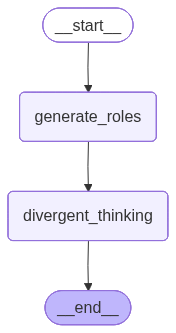

In [12]:
# 定义ReAct子图的输出Schema
class ReActOutput(TypedDict):
    roles: list[str]
    responses: list[str]

# 创建图
react_builder = StateGraph(
    state_schema=ReActState,
    output_schema=ReActOutput
)

# 添加节点
react_builder.add_node('generate_roles', generate_roles)
react_builder.add_node('divergent_thinking', divergent_thinking)

# 添加边
react_builder.add_edge(START, 'generate_roles')
react_builder.add_edge('generate_roles', 'divergent_thinking')
react_builder.add_edge('divergent_thinking', END)

# 编译图
react_graph = react_builder.compile(name='divergent-thinking')
react_graph

### 2）测试工作流

运行这个工作流，看看结果是否符合预期。

In [13]:
# 调用图
res = react_graph.invoke({"roles": roles, "n": 5})

assert len(res["roles"]) == len(res["responses"])

for role, resp in zip(res["roles"], res["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【佛系养生男】
随缘不扰，静待花开；你若安好，便是晴天。

【电竞热血少年】
女神在峡谷等我超神后回城再聊，这波团战不能输！

【高冷禁欲系学长】
嗯，看到了。

【温柔咖啡师】
刚刚在为你手冲一杯温柔的拿铁，希望香气能替我轻轻说一句：想你了。

【神秘塔罗占卜师】
星辰未动，静待其时；她不回你，或许命运正为你铺另一条路。



### 3）并行运行两个子图

现在我们有两个工作流：`doge_graph` 和 `react_graph`，下面将它们并联起来，放进一个父图之中。

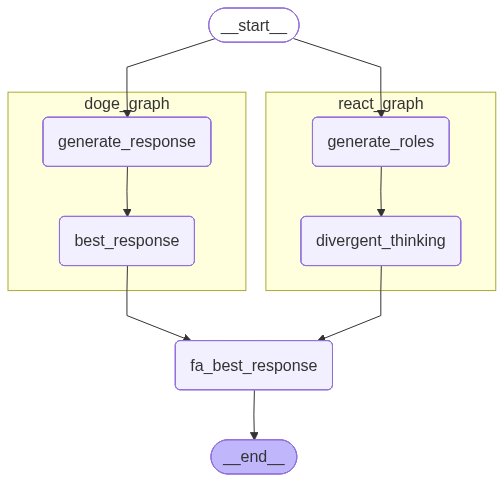

In [14]:
# 父图的全局Schema
class EntryGraphState(TypedDict):
    roles: Annotated[list, operator.add]
    n: int
    responses: Annotated[list, operator.add]
    best_response: str

# 父图的最佳回复节点：返回最佳回复
def fa_best_response(state: EntryGraphState):
    responses = "\n\n".join(state["responses"])
    prompt = best_response_prompt.format(responses=responses)
    response = llm.with_structured_output(BestResponse).invoke(prompt)
    return {"best_response": state["responses"][response.id]}

# 创建父图
fa_builder = StateGraph(EntryGraphState)

# 添加节点
fa_builder.add_node("doge_graph", doge_builder.compile())
fa_builder.add_node("react_graph", react_builder.compile())
fa_builder.add_node("fa_best_response", fa_best_response)

# 添加边
fa_builder.add_edge(START, "doge_graph")
fa_builder.add_edge(START, "react_graph")
fa_builder.add_edge("doge_graph", "fa_best_response")
fa_builder.add_edge("react_graph", "fa_best_response")
fa_builder.add_edge("fa_best_response", END)

# 编译图
fa_graph = fa_builder.compile(name='father-graph')

# 将 xray 参数设为 1 会显示嵌套图的内部结构
display(Image(fa_graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
# 调用图
response = fa_graph.invoke({"roles": roles[3:6], "n": 5})

这里的最佳回复，是从两个子图的所有回复中产生的最佳回复。你觉得它的质量变高了吗？( ﾟ∀。)

In [16]:
# 最佳回复
print(f"最受 {model_name} 喜爱的回复：{response['best_response']}")

最受 qwen3-max 喜爱的回复：没关系呀，等你有空再回我就好，不着急～


In [17]:
# 所有回复
assert len(response["roles"]) == len(response["responses"])

for role, resp in zip(response["roles"], response["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【渣男】
刚在忙，没看到消息，不过你一不说话我就开始想你了。

【奶狗弟弟】
姐姐是不是在忙呀？不着急回我，但我会一直乖乖等你的～

【社恐宅男】
刚刚在打游戏/看番，看到消息有点紧张，不知道怎么回才好……你还好吗？

【高冷霸总】
看来我的时间，还不值得你回一句。

【文艺诗人】
若你如月隐云后，我便作夜风轻叩；不扰清辉，只待回眸。

【搞笑段子手】
女神，我刚去银河系客服投诉了，说你已读不回影响宇宙和平，他们让我等你上线再派流星雨来提醒你～

【温柔学长】
没关系呀，等你有空再回我就好，不着急～

【神秘占卜师】
星辰沉默，非因无言，而是命运正为你编织一场更盛大的重逢。

